# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

device(type='cpu')

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'Seeds'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([210, 7]), torch.Size([210]), 210, 7, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.4410, 0.5021, 0.5708, 0.4865, 0.4861, 0.1893, 0.3452],
        [0.4051, 0.4463, 0.6624, 0.3688, 0.5011, 0.0329, 0.2152],
        [0.3494, 0.3471, 0.8793, 0.2207, 0.5039, 0.2515, 0.1507],
        [0.3069, 0.3161, 0.7931, 0.2393, 0.5339, 0.1942, 0.1408],
        [0.5241, 0.5331, 0.8648, 0.4274, 0.6643, 0.0767, 0.3230],
        [0.3579, 0.3719, 0.7895, 0.2742, 0.4861, 0.2206, 0.2152],
        [0.3872, 0.4298, 0.6515, 0.3739, 0.4483, 0.3668, 0.3447],
        [0.3324, 0.3492, 0.7532, 0.2934, 0.4790, 0.2516, 0.2368],
        [0.5704, 0.6302, 0.6044, 0.6498, 0.5952, 0.1658, 0.6686],
        [0.5524, 0.5868, 0.7250, 0.5546, 0.6237, 0.1565, 0.4993]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))

random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_valid])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_valid-E_test])

len(train_data), len(valid_data), len(test_data)

(126, 42, 42)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Set random seed

In [11]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, config.N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(config.N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=7, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=config.lr)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, valid_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.52381 | Loss: 1.090845704
| Epoch:   500 | Accuracy: 0.95238 | Loss: 0.300190568
| Epoch:  1000 | Accuracy: 0.95238 | Loss: 0.300314635
| Epoch:  1500 | Accuracy: 0.95238 | Loss: 0.301921904
| Epoch:  2000 | Accuracy: 0.95238 | Loss: 0.300308853
| Epoch:  2500 | Accuracy: 0.95238 | Loss: 0.299695522
| Epoch:  3000 | Accuracy: 0.95238 | Loss: 0.299556613
| Epoch:  3500 | Accuracy: 0.95238 | Loss: 0.299528927
| Epoch:  4000 | Accuracy: 0.95238 | Loss: 0.299523473
| Epoch:  4500 | Accuracy: 0.95238 | Loss: 0.299522310
| Epoch:  5000 | Accuracy: 0.95238 | Loss: 0.299522072
| Epoch:  5500 | Accuracy: 0.95238 | Loss: 0.299522042
| Epoch:  6000 | Accuracy: 0.95238 | Loss: 0.299522102
| Epoch:  6500 | Accuracy: 0.95238 | Loss: 0.299522161
| Epoch:  7000 | Accuracy: 0.95238 | Loss: 0.299522251
| Epoch:  7500 | Accuracy: 0.95238 | Loss: 0.299522340
| Epoch:  8000 | Accuracy: 0.95238 | Loss: 0.299522430
| Epoch:  8500 | Accuracy: 0.95238 | Loss: 0.299522489
| Epoch:  

(5308, 0.2995220124721527)

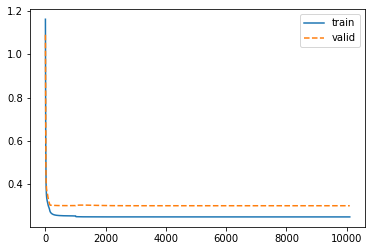

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(valid_loss_NN, '--', label='valid')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(valid_loss_NN)
best, valid_loss_NN[best]

## Save Model

In [ ]:
# with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
#     pickle.dump(NN, f)

## Evaluation

In [15]:
for x_test, y_test in test_loader:
    prediction_test = NN(x_test)
    p = torch.argmax(prediction_test, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_test = sum(pred_y == y_test.cpu().numpy()) / y_test.shape[0]
print(acc_test)

0.9523809523809523


In [16]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=7, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [17]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [18]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=config.lr)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, valid_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, valid_loader,
                                                                   config.m, config.T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33333 | Loss: 0.706688046 |
| Epoch:   500 | Accuracy: 0.95238 | Loss: 0.104160205 |
| Epoch:  1000 | Accuracy: 0.95238 | Loss: 0.106129341 |
| Epoch:  1500 | Accuracy: 0.95238 | Loss: 0.108649947 |
| Epoch:  2000 | Accuracy: 0.92857 | Loss: 0.147680089 |
| Epoch:  2500 | Accuracy: 0.90476 | Loss: 0.164802313 |
| Epoch:  3000 | Accuracy: 0.92857 | Loss: 0.170787290 |
| Epoch:  3500 | Accuracy: 0.90476 | Loss: 0.190782979 |
| Epoch:  4000 | Accuracy: 0.92857 | Loss: 0.205810100 |
| Epoch:  4500 | Accuracy: 0.92857 | Loss: 0.226912573 |
| Epoch:  5000 | Accuracy: 0.92857 | Loss: 0.238862336 |
| Epoch:  5500 | Accuracy: 0.92857 | Loss: 0.243007660 |
| Epoch:  6000 | Accuracy: 0.90476 | Loss: 0.263656884 |
| Epoch:  6500 | Accuracy: 0.92857 | Loss: 0.258279055 |
| Epoch:  7000 | Accuracy: 0.88095 | Loss: 0.284092993 |
| Epoch:  7500 | Accuracy: 0.88095 | Loss: 0.286107510 |
| Epoch:  8000 | Accuracy: 0.88095 | Loss: 0.286107510 |
| Epoch:  8500 | Accuracy: 0.88

(1116, 0.10105165839195251)

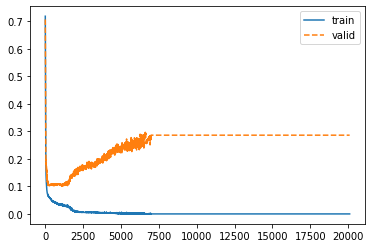

In [19]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(valid_loss_PNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, valid_loss_PNN[best]

## Save Model

In [ ]:
# with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
#     pickle.dump(PNN, f)

In [20]:
# PNN.to('cpu')

# Aging Aware PNN

In [21]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [ ]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [22]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.33548 | Loss: 1.045712948 |
| Epoch:     7 | Accuracy: 0.34381 | Loss: 0.893981695 |
| Epoch:    14 | Accuracy: 0.45821 | Loss: 0.773044348 |
| Epoch:    21 | Accuracy: 0.63262 | Loss: 0.608233154 |
| Epoch:    28 | Accuracy: 0.78333 | Loss: 0.441942245 |
| Epoch:    35 | Accuracy: 0.81881 | Loss: 0.342072874 |
| Epoch:    42 | Accuracy: 0.84405 | Loss: 0.315822005 |
| Epoch:    49 | Accuracy: 0.87095 | Loss: 0.281906635 |
| Epoch:    56 | Accuracy: 0.87143 | Loss: 0.253064901 |
| Epoch:    63 | Accuracy: 0.87345 | Loss: 0.246077210 |
| Epoch:    70 | Accuracy: 0.88143 | Loss: 0.239250958 |
| Epoch:    77 | Accuracy: 0.88202 | Loss: 0.224113986 |
| Epoch:    84 | Accuracy: 0.87536 | Loss: 0.249375120 |
| Epoch:    91 | Accuracy: 0.88167 | Loss: 0.211448878 |
| Epoch:    98 | Accuracy: 0.89012 | Loss: 0.200546354 |
| Epoch:   105 | Accuracy: 0.88762 | Loss: 0.207052857 |
| Epoch:   112 | Accuracy: 0.88512 | Loss: 0.212148830 |
| Epoch:   119 | Accuracy: 0.89

(146, 0.18775060772895813)

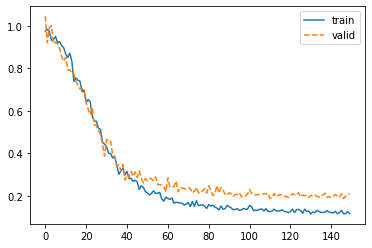

In [23]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

In [24]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.89417 | Loss: 0.189998835 |
| Epoch:    12 | Accuracy: 0.88988 | Loss: 0.193175375 |
| Epoch:    24 | Accuracy: 0.88726 | Loss: 0.198152691 |
| Epoch:    36 | Accuracy: 0.89821 | Loss: 0.198358163 |
| Epoch:    48 | Accuracy: 0.89726 | Loss: 0.192150533 |
| Epoch:    60 | Accuracy: 0.89202 | Loss: 0.195211604 |
| Epoch:    72 | Accuracy: 0.89560 | Loss: 0.188228056 |
| Epoch:    84 | Accuracy: 0.89381 | Loss: 0.190253764 |
| Epoch:    96 | Accuracy: 0.89107 | Loss: 0.200149551 |
| Epoch:   108 | Accuracy: 0.89179 | Loss: 0.194806293 |
| Epoch:   120 | Accuracy: 0.90095 | Loss: 0.192373350 |
| Epoch:   132 | Accuracy: 0.89631 | Loss: 0.184037030 |
| Epoch:   144 | Accuracy: 0.90179 | Loss: 0.189789534 |
| Epoch:   156 | Accuracy: 0.89952 | Loss: 0.188704595 |
| Epoch:   168 | Accuracy: 0.90488 | Loss: 0.188501000 |
| Epoch:   180 | Accuracy: 0.90417 | Loss: 0.189758897 |
| Epoch:   192 | Accuracy: 0.90940 | Loss: 0.180076703 |
| Epoch:   204 | Accuracy: 0.90

(244, 0.1626749038696289)

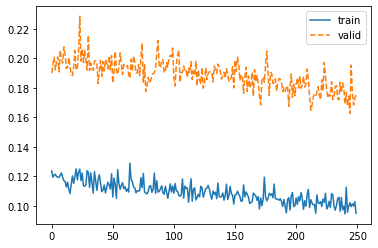

In [25]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

In [26]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.90774 | Loss: 0.174325272 |
| Epoch:    12 | Accuracy: 0.90321 | Loss: 0.180164665 |
| Epoch:    24 | Accuracy: 0.90702 | Loss: 0.175814942 |
| Epoch:    36 | Accuracy: 0.90929 | Loss: 0.171961129 |
| Epoch:    48 | Accuracy: 0.91143 | Loss: 0.171482712 |
| Epoch:    60 | Accuracy: 0.90167 | Loss: 0.181669027 |
| Epoch:    72 | Accuracy: 0.91667 | Loss: 0.178486481 |
| Epoch:    84 | Accuracy: 0.90917 | Loss: 0.174295232 |
| Epoch:    96 | Accuracy: 0.90833 | Loss: 0.177829951 |
| Epoch:   108 | Accuracy: 0.90560 | Loss: 0.173390538 |
| Epoch:   120 | Accuracy: 0.90952 | Loss: 0.172618702 |
| Epoch:   132 | Accuracy: 0.90798 | Loss: 0.174801201 |
| Epoch:   144 | Accuracy: 0.91155 | Loss: 0.171955079 |
| Epoch:   156 | Accuracy: 0.91012 | Loss: 0.167443871 |
| Epoch:   168 | Accuracy: 0.90929 | Loss: 0.167400166 |
| Epoch:   180 | Accuracy: 0.91012 | Loss: 0.169822186 |
| Epoch:   192 | Accuracy: 0.90893 | Loss: 0.171359032 |
| Epoch:   204 | Accuracy: 0.90

(151, 0.15574921667575836)

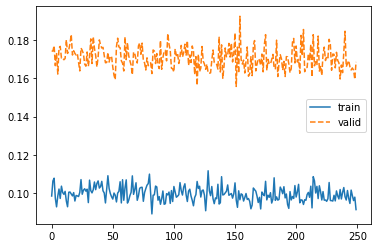

In [27]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

## Save Model

In [ ]:
# with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
#     pickle.dump(AAPNN, f)